# Week 10: Networks 2


Networks are mathematical representations of complex systems. We can use networks to gain various statistical insight about the system we're representing, and we can look for patterns at the meso-scale by employing *community detection* algorithms. This week we will explore the following:

* Network null models
* How to use a null model to infer the p-value of a result
* How a popular community detection algorithm works (and fails)

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx           # `pip install networkx`
import json
from collections import Counter
import community                # `pip install python-louvain` or `conda install -c auto python-louvain`

## Exercises

### Part 1: Network null models

**What is a null model?** Null models are alternative instances of data, that are used to assess the amount of signal that is due to pure randomness. For example, you might have
measured some signal in your data, like a large number of triangles (high average local clustering coefficient)
in your network, but before you go and report that to your boss you need to answer one crucial question: how does
this result compare with a *random* one? In other words, how can you be so sure that this high number of triangles
measured is not perfectly normal even in a random network of similar origin and therefore not very special after all? The answer: **you
create a null model to compare your result with!**

> Note: null models are a concept from the general field of statistics and therefore not just specific to
networks. You can use this statistical tool anytime you need to assess how likely it is that your result is random.

The most common type of null model is one where you shuffle links in your network, while preserving the degree
sequence. *(Recall, that the degree sequence is a list that stores the degree of each node. So if we shuffle and
preserve the degree sequence at the same time, it means that after all the link-shuffling is done, nodes will
have new neighbors, but the same number of neighbors)*. In this shuffled network (the null model), if you find that
there are far fewer triangles than in your real data then you can start to argue that your result is significant.

> Note: the term *null model* is a slight misnomer, as it is not a model per se, but rather an instance of the
data that is permuted in some way (usually under constraints, such as preservation of degree sequence), so it can
be taken to represent *randomness*. As such, there is no *model*, but rather an *instance* or simply *data*.

But that is just one comparison. What if the number of triangles in the random data–the null model–is smaller, but
not that much smaller? Can you still say your result is significant? Well, the trick (although computationally expensive
as you will come to learn) is to do MANY comparisons. 1000 is not a bad start. For each comparison, you check if
the number of triangles in your real data is bigger. After you have compared one thousand times you compute **the
fraction of times** your number of triangles in the real data was bigger than in the random data. Guess what that
number (between 0 and 1) is called? **The p-value**. And what does it communicate? **The probability that your result
is random!**

^ That's some useful statistics right there!

Please make sure you have **READ AND UNDERSTOOD** the above, as you will otherwise have a very hard time completing the
following exercises.

**Ex. 10.1.1**: The method described above works for anything you might want to measure in a network. Let's say,
instead of measuring the number of triangles, you measured the network diameter. Explain in your own words how to
assess the statistical significance (the p-value) of such a measurement, using the same null model.

### Answer 10.1.1

Before computing the p-value I will decide on a significance level at which I will evaluate whether the pattern found in the real data is "significantly" different from a random one. 

In econometrics, one often uses a significance level of 5%, so I would use that as well when producing 1000 null models.

The relevant statistics to compute is then the distance between the network diameter in the real data and the 1000 null models.
The H0 in this particular case is that the network diameter in the real data is random.
If the p-value is below 5% we wold reject the null and say that the observed pattern is not random at a 5% significance level.

**Ex. 10.1.2**: The null model described above rewires a network while preserving the degree distribution. [Here](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html#networkx.algorithms.swap.double_edge_swap) is
implementation of it in NetworkX. In your own words, describe:
1. how it works and why it achieves randomness
without changing the degree distribution.
2. Also describe what can sometimes happen and why the desired number of swaps `nswaps` is only an upper-bound on
the number of swaps.

### Answer 10.1.2

1) This works beacuse reshuffling the links is possible without changing the degree seqence, as we will then be able to make sure that each node has the same number of neighbors albeit not necessearily the same ones.

2) While doing the reshuffling the implementation in NetworkX may encounter a problem of not being able to find the appropriate number of neighbors. To ensure that the command does not fail there is an option of specifying a max number of swaps to make sure that the entire procedure does not crash while trying to find an impossible swap


**Ex. 10.1.3**: Load the Facebook wall-post network from last week, into a `networkx.Graph` object called `G`.
1. Measure the average local clustering coefficient (ALCC) of `G`. Print it.
2. Over 1000 iterations, measure the ALCC for `G` where, in each iteration, you have made 1000 edge swaps using 
`double_edge_swap`. Append the measured ALCC values to a list. Print the average of this list. *Note: this will
obviously take some time**.
3. Report the p-value of your result, the ALCC of the real data.
4. Make a histogram that displays the distribution of ALCC values in the null models as a histogram as well as
the ALCC of the real data as a vertical line. Comment on this result. Does it make sense?

In [ ]:
# Read data
import pandas as pd

data = pd.read_csv(
    "facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

In [ ]:
# Create a nx.Graph from this dataframe
G= nx.from_pandas_edgelist(data, 'user1', 'user2', create_using=nx.Graph)

#1)
TRUE_ALCC=nx.average_clustering(G)
TRUE_ALCC

In [ ]:
#2) 

from tqdm import tqdm
ALCC=[]

for x in tqdm(range(1000)):
    G_=G.copy()
    G_=nx.double_edge_swap(G_, nswap=1000, max_tries=5000)
    alcc=nx.average_clustering(G_)
    ALCC.append(alcc)
     
    

In [ ]:
#3) compute p

count_equal_to_true=sum(1 for x in ALCC if x==TRUE_ALCC)
p=count_equal_to_true/len(ALCC)

print("True ALCC: " + str(TRUE_ALCC))

print("p (share of null models with ALCC equal to the true ALCC): " + str(p))

# Would it make more sense to compute the number of null models within a range of the true value?
# I know it wouldn't really make a difference in this particular case, but in general,
# would it then be a better approach to evaluate if the pattern in the real data is random?
# Especially, as a metric such as the ALCC is computed with so many decimals...

In [ ]:
# 4) Plot distribution
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
g=sns.distplot(ALCC)
plt.xlabel("Distribution of ALCC in null models", fontsize="large")
plt.axvline(x=TRUE_ALCC, color="green", label="True ALCC")
plt.legend(loc="upper right")

4) cnt'd

In this case the true ALCC is fra greater than what we observe in the random null models, which leads us to conclude that the pattern of clustering in the real data is not due to randomness

### Part 2: Community detection

Communities are little lumps of nodes in a network that are unusually strongly connected. Your family is a community, and your friend group from work or university is another community. While there is no one true definition of what a community is, there are many many different methods and algorithms for finding them. Here we will work with one of the most popular ones: [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity). The following exercises will walk you through the fundamentals of this method, and finally have you apply it to the network you used last week.

#### The modularity function

> **Ex. 10.2.1**: Assume you have a network where nodes and links tend to form lumps here and there. Imagine you now reach for your pen, and start labeling these nodes with group names (or ids) that feel appropriate according to how they are lumped together. If your partition is "good", nodes that are connected in groups should intuitively have the same label, while nodes that are distant and disconnected should have different labels. Modularity is a function that can be used to measure, by this logic, *how good* your partition is. It is in technical terms a *utility function*, and it looks like this:
> <br><br>
> $$ Q = \dfrac{1}{2m}\sum_{ij}{\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]\delta(c_i, c_j)}.$$
> <br>
> Your job in this problem is to explain this equation. When I look at daunting math I find it calming to try and read it as if it were code. Since all math can be implemented in code, all math can be broken into parts, where each part does a seperate thing. Answer each question below seperately:


1. In code, a sum, $\sum$, is like a `for` loop, where in every iteration you increment a variable. In the equation for modularity the little $ij$ subscript tells is what the sum is looping over (like `for ij in sumloop`). But what is $ij$?

Answer: i and j are nodes in the network. Thus, ij are node pairs. The summation tells us that we sum over all node pairs in the network


2. In each iteration of the sum, the delta function $\delta(c_i, c_j)$ is used, where $c_i$ is the community label of node $i$. The delta function is a very simple program that returns 0 if the two input values are different and 1 if they are they same. How would you implement the delta function in code? What is it used for in the modularity equation?

Answer: I would code up a separate function returning 1 if $c_i==c_j$. 
In the equation it has the property of discarding node pairs that are not in the same community 

3. Inside the sum we use the term $\frac{k_ik_j}{2m}$ as our *null model*. $k$ is the degree sequence (so $k_i$ is the degree of node $i$) and $m$ is the sum of all link weights. Explain what this null model measures. Could we have used other null models?

Answer: $k_ik_j$ is the number of ways in which node i and j can connect. This expression is then normalised by m to yield our null model $\frac{k_ik_j}{2m}$, which expresses the expected weight between node i and j in a random network with a similar degree. 

4. The sum subtracts the null model from $A_{ij}$ and adds the result to its final value if the delta function evaluates to 1. What is the point of only summing over this difference when the delta function is 1?

Answer: The term in the brackets allows us to get an impression of how the edge weights in the actual network differs from those of a random network. As we only want to assess connectivity within each community we only sum over nodes that are in the same community. 

5. The sum term is normalized by $2m$. Why exactly $2m$?

Answer: This is a way of scaling by the possible number of connections in the network.

6. Summarize your insight gained from answering the above questions. In your own words, explain how the modularity function works. Use 1-3 sentences.

Answer: The function works by constructing a measure that allows for a comparison of the differences in connectivity between nodes in the actual network and those of a random one with a similar degree. 

> **Ex. 10.2.2**: Implement the modularity function. Write a Python function that takes as input an adjacency matrix and a label vector, and returns the modularity. Compute and print the modularity for the ones given below. The correct result is 0.122.

In [2]:
import numpy as np

A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

def delta(ci, cj):
    if ci==cj:
        return 1
    else:
        return 0

def modularity(A, c):
    """Compute modularity for a labeled network.
    
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        c : list of ints
            Community labels. Length N.
    
    Output
    ------
        out : float
    """
    n = A.shape[0] # Matrix is symmetric
    Q = 0
    m = A.sum() / 2
    for i in range(n):
        ki = A[i,:].sum()
        for j in range(n):
            kj = A[:,j].sum()
            Q += (A[i,j] - ki*kj/(2*m)) * delta(c[i], c[j])
    return Q/(2*m)

In [3]:
modularity(A, c)

0.12244897959183675

> **Ex. 10.2.3**: The example labeling, `c`, was not optimal. Find the optimal one and print its modularity score.

>*Hint: Either just try a bunch of different label combinations or visualize the network so you can see what is optimal. Using pen and paper here is no shame.*

#### Finding the best communities

OK, so we are now able to evaluate the quality of a partition. But how do we find the best partition? Modularity gives us a way to measure *how good* our partition is, but it does not tell of how to find the best one. For that we need some sort of algorithm. The *Louvain method* is that algorithm.

It works in the following steps:
1. Set every node to be its own community (initiate `c = [0, 1, 2, 3, 4, 5]`).
2. Compute the modularity.
3. Now pick a random node.
    1. For every neighbor it has, try giving it the neighbor's label, and compute the change in modularity.
    2. If any of those relabelings led to an increase in modularity, choose the relabeling with the greatest increase.
4. Repeat 2-3 until modularity ceases to increase for any relabelings.

In [4]:
def put(array, index, value):
    _arr = array.copy()
    _arr[index] = value
    return _arr

def louvain(A, max_iter = 50, k = 10):
    # 1) -2) set starting values and compute starting modularity
    c = np.arange(A.shape[0])
    Q = modularity(A,c)
    noimp = 0
    
    # Specify that we only want the function to continue its iterative process as long as there is a significant improvement in its partition
    for _ in range(max_iter):
        if noimp > k:
            break
        
        #3) Pick random note
        i = np.random.randint(A.shape[0])
        #3a) for all neighbors compute change in modularity when changing label of i to that of neighbor j
        js = np.where(A[i, :] == 1)[0]
        delta_Qs = [modularity(A, put(c, i, c[j])) - Q for j in js]
    
        #3b) choose labelling with greatest increase in modularity (if any)
        if max(delta_Qs) <= 0:
            noimp += 1
            continue
        
        else:
            noimp = 0
            j_star = js[np.argmax(delta_Qs)]
            c = put(c, i, c[j_star])
            old_Q = Q
            Q = modularity(A, c)
    
    return c

In [5]:
louvain(A)

array([1, 1, 1, 5, 5, 5])

Admittedly, for this part I just used your code. I am just not sure I understand the usefulness of the put-function. The outcome when I call the louvain(A)-function still keeps alternating between:

array([1, 1, 1, 5, 5, 5])

and

array([0, 0, 0, 4, 4, 4])

Why is this the case?

> **Ex. 10.2.BONUS**: Implement the Louvain method, and show that it gives the labeling for `A`. A cool portfolio project for your Github account here!

#### Communication communities on Facebook

Now let's work with some real data. Whip out the network you created **last week**, we will be using that again. Apply again the **threshold** you created in **Ex. 9.2.4**.

> **Ex. 10.2.4**: Find the communities in this networks. Print the number of communities and plot the distribution of community sizes. See something interesting? Comment on this distribution.

>*Hint: You're welcome to use your own implementation of the Louvain algorithm (pretty badass if you can), but there's also a widely used Python implementation that you can take off the shelf. Go ahead and install `python-louvain` by running `conda install -c auto python-louvain` in a terminal. After installation, import it with `import community`, and use `community.best_partition` to get a node-community dictionary.*

In [6]:
import pandas as pd

data = pd.read_csv(
    "facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)


#I implement same function as last week but create an undirected graph as the python-louvain function doesn't work well with directed graphs
def undirectedGraph(t0, t1):
    data_t = data.loc[data.timestamp.between(t0, t1)]
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')
    G_t = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)
    return G_t

t0 = data.timestamp.max() - 86400 * 10  # Lower bound of time-slice (here: 10 days before last wall post)
t1 = data.timestamp.max()              # Upper bound of time-slice

DG10 = undirectedGraph(t0, t1)

In [7]:
import community

partition=community.best_partition(DG10)

cluster, counts = zip(*Counter(partition.values()).items())

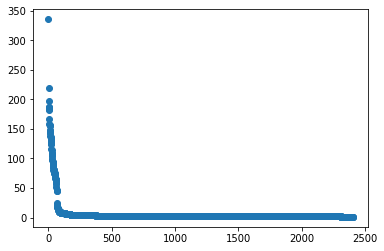

In [9]:
#Plot distribution

plt.plot(sorted(counts, reverse = True), 'o')


The distribution of nodes per cluster is highly skewed

> **Ex. 10.2.5**: Visualize the network, similarly to how you did it last week but this time coloring the nodes by their labels.
>
> *Hint: [Here](https://netwulf.readthedocs.io/) are the `netwulf` docs. Fiddle around with the layout a little it always makes the network look nicer.*

### Answer

Unfortunately, I cannot get netwulf to work properly

> **Ex. 10.2.6:** Maybe the communities you observed in the previous exercise were not as pretty as you were hoping.
Admittedly, the Facebook wallpost network is not the most modular network anyway, but still it examplifies a serious
problem with the Modularity score as a utility function for community detection. Can you explain what this problem is,
and why it becomes increasingly severe as the network grows larger?
>
> *Hint: it has something to do with the null model that Modularity uses*.

### Answer

This is a bit difficult to comment on myself, when I couldn't get the visualization to work...

But I have read your answer to the question and understand that it is related to the degree preserving property of the null model, which can be prolematic when the connectivity is limited

> *Final note: there are many other community detection algorithms out there. Check out the [NetworkX docs](https://networkx.github.io/documentation/stable/reference/algorithms/community.html)
for some easy-to-use alternatives to Modularity. Also you may want to have a look at [Infomap](https://mapequation.github.io/infomap/python/)
especially if you are working with networks where links represent flow (like transactions, exchange, citations, hyperlinks, etc). It usually gives amazing results.*